In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import re

from tqdm import tqdm

random_state = 12345

import json
import os

In [274]:
train_ds = pd.read_csv('data/train_dataset.csv')
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          37224 non-null  object 
 1   time          37224 non-null  int64  
 2   target        37224 non-null  float64
 3   temp          37224 non-null  float64
 4   temp_pred     37136 non-null  float64
 5   weather_pred  37136 non-null  object 
 6   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 2.0+ MB


In [275]:
train_ds['date'] = pd.to_datetime(train_ds['date'])
train_ds['year'] = train_ds['date'].dt.year
train_ds['month'] = train_ds['date'].dt.month
train_ds['day_of_week'] = train_ds['date'].dt.dayofweek
train_ds['day'] = train_ds['date'].dt.day
train_ds['day_of_year'] = train_ds['date'].dt.dayofyear

In [276]:
# функция формирует колонки 'cloudy', 'rainy', 'windy', 'clear', 'some_number'
# в колонках число, которое 0 при отсутсвии упоминания явления в weather_pred или степень упоминания
# функция дает в колонках номер первого списка, элемент которого есть в строке плюс 1
# списки cloudy_list, rainy_list, windy_list, clear_list можно модифицировать
# соответственно, можно экспериментировать с расположением значений в списках
# например, сейчас 'дождь', 'снег', 'д+сн' - первая степень  дождя, а 'гроз', 'ливень' - вторая
# а можно сделать снег второй, а грозу с ливнем убрать в третью
# также сделал отдельный список для "ясности", чтобы выделить 'ясно' и 'солнечно'

def in_what_list(weather, big_list):
    for list_number, small_list in enumerate(big_list):
        if any(word in weather for word in small_list):
            return list_number+1
    return 0

def weather_split2(row):
    weather = row['weather_pred']
    cloudy_list = [['проясн', 'пер.об.', 'п/об'], ['пасм', 'обл']]
    rainy_list = [['дождь', 'снег', 'д+сн'], ['гроз', 'ливень']]
    windy_list = [['вет'],['штор']]
    clear_list = [['проясн'], ['ясно'], ['солнеч']]
    numbers = re.findall(r'\d+', weather)
    cloudy = in_what_list(weather, cloudy_list)
    rainy = in_what_list(weather, rainy_list)
    windy = in_what_list(weather, windy_list)
    clear = in_what_list(weather, clear_list)
    rain_probability = 0 if len(numbers)==0 else int(numbers[0])
    has_rain_probability = int(len(numbers)==0)
    return cloudy, rainy, windy, clear, rain_probability, has_rain_probability

def fill_weather_columns(df):
    df['weather_pred'] = df['weather_pred'].fillna('')
    df['cloudy'], df['rainy'], df['windy'], df['clear'], df['rain_probability'], df['has_rain_probability'] = \
                zip(*df.apply(weather_split2, axis=1))
    return df

train_ds = fill_weather_columns(train_ds)



In [277]:
def sunrise(df):
    latitude = 54.7065
    longitude = 20.511

    sun = Sun(latitude, longitude)

    df['day'] = df.index
    df['sunrise'] = ('2019-01-01 00:00:00')
    df['sunset'] = ('2019-01-01 00:00:00')

    for i in range(len(df_train_orig['day'])):
        df['sunrise'][i] = (sun.get_local_sunrise_time(datetime.date(df['day'][i])) 
                                        - timedelta(hours=1)).strftime('%Y-%m-%dZ%H:%M:%S')
        df['sunset'][i] = (sun.get_local_sunset_time(datetime.date(df['day'][i])) 
                                        - timedelta(hours=1)).strftime('%Y-%m-%dZ%H:%M:%S')
    
    df = df.drop(['day'], axis= 1)

    df['sunset'] = pd.to_datetime(df['sunset'], format='%Y-%m-%dZ%H:%M:%S')
    df['sunrise'] = pd.to_datetime(df['sunrise'], format='%Y-%m-%dZ%H:%M:%S')
    df['sun_time'] = df['sunset'] - df['sunrise']
         
    return df

In [278]:
daylight_2020 = pd.read_csv('data/daylight_data_2020.csv', sep=';').reset_index()
daylight_2020.head(10)
daylight_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           366 non-null    float64
 1   Восход                          366 non-null    object 
 2   Зенит                           366 non-null    object 
 3   Закат                           366 non-null    object 
 4   Долгота дня                     366 non-null    object 
 5   Unnamed: 4                      366 non-null    object 
 6   Начало астрономических сумерек  366 non-null    object 
 7   Начало навигационных сумерек    366 non-null    object 
 8   Начало гражданских сумерек      366 non-null    object 
 9   Конец гражданских сумерек       366 non-null    object 
 10  Конец навигационных сумерек     366 non-null    object 
 11  Конец астрономических сумерек   366 non-null    object 
dtypes: float64(1), object(11)
memory usa

In [279]:
def split_hm_time(s):
    v = s.split(':')
    #return( pd.to_timedelta(int(v[0]), unit='h') + pd.to_timedelta(int(v[1]), unit='m'))
    return( int(v[0])*60 + int(v[1]))

def split_time(s, units):
    v = s.split(':')
    return( sum( [ pd.to_timedelta(int(val), unit=units[i]) for i,val in enumerate(v) ], datetime.timedelta() ) )

split_time('10:10', 'hm')

Timedelta('0 days 10:10:00')

In [280]:
years = [2019, 2020, 2021, 2022, 2023]
daylight_column_names = ['date', 'sunrise', 'midday', 'sunset', 'duration', 'difference', 
                         'astro_sunrise', 'navigational_sunrise', 'civil_sunrise',
                         'civil_sunset', 'navigational_sunset', 'astro_sunset']
daylight_non_hm_names = ['date', 'duration', 'difference']
daylight_hm_names = daylight_column_names.copy()
for name in daylight_non_hm_names:
    daylight_hm_names.remove(name)
daylight_table = []
for i, year in enumerate(years):
    daylight_table.append(pd.read_csv(f'data/daylight_data_{year}.csv', sep=';').reset_index())
    daylight_table[i].columns = daylight_column_names
    daylight_table[i]['date'] = daylight_table[i]['date'].apply(lambda x: '{0:04d}-{1:02d}-{2:02d}'.format(year, round( (x % 1)*100), int(x)))
    daylight_table[i]['date'] = pd.to_datetime(daylight_table[i]['date'])
    #for column in daylight_column_names[1:]:
        #daylight_table[i][column] = pd.to_timedelta(daylight_table[i][column])
    #daylight_table[i]['sunrise'] = pd.to_timedelta(daylight_table[i]['sunrise'], unit='m')

    #daylight_table[i]['sunrise'] = daylight_table[i]['sunrise'].apply(split_hm_time)
    for name in daylight_hm_names:
        daylight_table[i][name] = daylight_table[i][name].where(daylight_table[i][name]!='—', '0:0').apply(split_hm_time)

daylight_df = pd.concat(daylight_table)

daylight_df['civil_day'] = daylight_df['civil_sunset'] - daylight_df['civil_sunrise']
daylight_df['day_duration'] = daylight_df['sunset'] - daylight_df['sunrise']

daylight_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665 entries, 0 to 203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1665 non-null   datetime64[ns]
 1   sunrise               1665 non-null   int64         
 2   midday                1665 non-null   int64         
 3   sunset                1665 non-null   int64         
 4   duration              1665 non-null   object        
 5   difference            1665 non-null   object        
 6   astro_sunrise         1665 non-null   int64         
 7   navigational_sunrise  1665 non-null   int64         
 8   civil_sunrise         1665 non-null   int64         
 9   civil_sunset          1665 non-null   int64         
 10  navigational_sunset   1665 non-null   int64         
 11  astro_sunset          1665 non-null   int64         
 12  civil_day             1665 non-null   int64         
 13  day_duration       

In [281]:
# все числа даны в минутах от начала суток
daylight_df.head()

,date,sunrise,midday,sunset,duration,difference,astro_sunrise,navigational_sunrise,civil_sunrise,civil_sunset,navigational_sunset,astro_sunset,civil_day,day_duration
0,2019-01-01,542,762,982,07:19:58,+1:14,406,450,497,1027,1074,1117,530,440
1,2019-01-02,542,762,983,07:21:19,+1:21,406,450,497,1028,1074,1118,531,441
2,2019-01-03,541,763,984,07:22:46,+1:27,406,450,497,1029,1075,1119,532,443
3,2019-01-04,541,763,985,07:24:21,+1:35,406,450,497,1030,1077,1120,533,444
4,2019-01-05,541,764,987,07:26:03,+1:42,406,450,497,1031,1078,1121,534,446


In [282]:
daylight_columns_for_merge = ['date', 'sunrise', 'midday', 'sunset', 'day_duration', 'civil_day']
train_ds = train_ds.merge(daylight_df[daylight_columns_for_merge], on='date')

In [283]:
train_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year',
       'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability', 'sunrise', 'midday', 'sunset', 'day_duration',
       'civil_day'],
      dtype='object')

In [284]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,...,rainy,windy,clear,rain_probability,has_rain_probability,sunrise,midday,sunset,day_duration,civil_day
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,0,0,1,542,762,982,440,530
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,0,0,1,542,762,982,440,530
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,0,0,1,542,762,982,440,530
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,1,0,0,1,542,762,982,440,530
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,1,0,0,1,542,762,982,440,530


In [285]:
df_holidays = pd.read_csv('data/holidays.csv')
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

In [286]:
# Assuming df_holidays and train_ds are your dataframes
train_ds = pd.merge(train_ds, df_holidays, on='date', how='left')

# Fill NaN values with 0
train_ds['holidays'].fillna(0, inplace=True)
train_ds['preholidays'].fillna(0, inplace=True)

# Convert to int
train_ds['holidays'] = train_ds['holidays'].astype(int)
train_ds['preholidays'] = train_ds['preholidays'].astype(int)

In [287]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,...,clear,rain_probability,has_rain_probability,sunrise,midday,sunset,day_duration,civil_day,holidays,preholidays
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,0,1,542,762,982,440,530,0,0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,0,1,542,762,982,440,530,0,0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,0,1,542,762,982,440,530,0,0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,0,1,542,762,982,440,530,0,0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,0,1,542,762,982,440,530,0,0


In [288]:
# создаем столбец 'temp_last_day'
train_ds['temp_last_day'] = train_ds['temp'].shift(24)

# заполняем пропущенные значения в 'temp_last_day'
train_ds['temp_last_day'].fillna(method='bfill', inplace=True)

# создаем столбцы с временными лагами для 'target'
lags = [24, 48, 72, 7*24, 14*24]
for lag in lags:
    train_ds[f'target_lag_{lag}'] = train_ds['target'].shift(lag)

# заполняем пропущенные значения в столбцах с лагами
for lag in lags:
    train_ds[f'target_lag_{lag}'].fillna(0, inplace=True)

In [289]:
# создаем столбец 'temp_last_day'
#train_ds['avg_temp_last_day'] = train_ds.groupby(by='date')['temp_pred'].transform('mean')
#train_ds['max_temp_last_day'] = train_ds.groupby(by='date')['temp_pred'].transform('max')
#train_ds['min_temp_last_day'] = train_ds.groupby(by='date')['temp_pred'].transform('min')
#df.groupby('dummy')['returns'].agg(Mean='mean', Sum='sum')
print(len(train_ds))
#date_temp = train_ds.groupby(by='date')['temp'].agg(avg_temp_last_day='mean', max_temp_last_day='max', min_temp_last_day='min').shift(1)
date_temp = train_ds.groupby(by='date')['temp'].agg(max_temp_last_day='max', min_temp_last_day='min').shift(1)
#train_ds = train_ds.merge(date_temp, on='date')[train_ds['date']>'2019-01-01']
print(len(train_ds))
train_ds.info()

40080
40080
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40080 entries, 0 to 40079
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  40080 non-null  datetime64[ns]
 1   time                  40080 non-null  int64         
 2   target                40080 non-null  float64       
 3   temp                  40080 non-null  float64       
 4   temp_pred             39992 non-null  float64       
 5   weather_pred          40080 non-null  object        
 6   weather_fact          40079 non-null  object        
 7   year                  40080 non-null  int64         
 8   month                 40080 non-null  int64         
 9   day_of_week           40080 non-null  int64         
 10  day                   40080 non-null  int64         
 11  day_of_year           40080 non-null  int64         
 12  cloudy                40080 non-null  int64         
 13  rain

In [290]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,...,day_duration,civil_day,holidays,preholidays,temp_last_day,target_lag_24,target_lag_48,target_lag_72,target_lag_168,target_lag_336
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,440,530,0,0,2.9,0.0,0.0,0.0,0.0,0.0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,440,530,0,0,2.9,0.0,0.0,0.0,0.0,0.0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,440,530,0,0,2.9,0.0,0.0,0.0,0.0,0.0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,440,530,0,0,2.9,0.0,0.0,0.0,0.0,0.0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,440,530,0,0,2.9,0.0,0.0,0.0,0.0,0.0


In [323]:
feature_cols = list(train_ds.columns)
#daylight_columns_for_merge = ['date', 'sunrise', 'midday', 'sunset', 'day_duration', 'civil_day']
#drop_list = ['target', 'date', 'day_of_year', 'weather_pred', 'weather_fact', 'temp', 'sunrise', 'midday', 'sunset']
drop_list = ['target', 'day_of_year', 'weather_pred', 'weather_fact', 'temp'] + ['sunrise', 'midday', 'sunset', 'day_duration', 'civil_day']
#drop_list = ['target', 'date', 'day', 'month', 'weather_pred', 'weather_fact', 'temp'] + ['sunrise', 'midday', 'sunset', 'day_duration', 'civil_day']
for name in drop_list:
    feature_cols.remove(name)

feature_cols

['date',
 'time',
 'temp_pred',
 'year',
 'month',
 'day_of_week',
 'day',
 'cloudy',
 'rainy',
 'windy',
 'clear',
 'rain_probability',
 'has_rain_probability',
 'holidays',
 'preholidays',
 'temp_last_day',
 'target_lag_24',
 'target_lag_48',
 'target_lag_72',
 'target_lag_168',
 'target_lag_336']

In [347]:
features = train_ds[feature_cols]
target = train_ds['target']

In [293]:
features.head()

,time,temp_pred,year,month,day_of_week,day,cloudy,rainy,windy,clear,rain_probability,has_rain_probability,holidays,preholidays,temp_last_day,target_lag_24,target_lag_48,target_lag_72,target_lag_168,target_lag_336
0,0,2.0,2019,1,1,1,2,0,1,0,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
1,1,2.0,2019,1,1,1,2,0,1,0,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
2,2,2.0,2019,1,1,1,2,0,1,0,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
3,3,2.0,2019,1,1,1,2,0,1,0,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
4,4,2.0,2019,1,1,1,2,0,1,0,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0


In [349]:
def features_split(features, target, date):
    date_train = features[features['date']<date]['date']
    features_train = features[features['date']<date]
    target_train = target[features_train.index]

    date_valid = features[features['date']>=date]['date']
    features_valid = features[features['date']>=date]
    target_valid = target[features_valid.index]
    features_train = features_train.drop('date', axis=1)
    features_valid = features_valid.drop('date', axis=1)
    return features_train, features_valid, target_train, target_valid, date_train, date_valid


In [375]:
def features_interval(features, target, date1, date2):
    features_interval = features[ (features['date']>=date1) & (features['date']<date2) ]
    target_interval = target[features_interval.index]
    date_interval = features[ (features['date']>=date1) & (features['date']<date2) ]['date']
    features_interval = features_interval.drop('date', axis=1)
    return features_interval, target_interval, date_interval

In [304]:
#features_train = features[features['year']<2023]
#target_train = target[features_train.index]
#features_valid = features[features['year']==2023]
#target_valid = target[features_valid.index]

In [305]:
#features_train = features[features['year']<2022]
#target_train = target[features_train.index]
#features_valid = features[features['year']==2022]
#target_valid = target[features_valid.index]

In [380]:
#features_train, features_valid, target_train, target_valid, date_train, date_valid = features_split(features, target, '2022-01-01')
features_train, target_train, date_train = features_interval(features, target, '2019-01-01', '2022-01-01')
features_valid, target_valid, date_valid = features_interval(features, target, '2022-01-01', '2023-01-01')

In [381]:
dates = ['2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01', '2023-01-01']
quarters = []
for i in range(4):
    f, t, d = features_interval(features, target, dates[i], dates[i+1])
    quarters.append({'features':f, 'target':t, 'date':d})

In [382]:
def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)

In [383]:
# класс предлагается инициализировать, затем брать значения параметра из current_value 
# и регистрировать значения метрики методом add_metric_value, пока add_metric_value не вернет True

# параметры инициализации: 
# initial_values - начальный вектор значений параметра, может быть любой длины
# stop_relation - целевое отношение соседних значений параметра для остановки поиска
# step_method - способ формирования трех точек для первой параболы дугой вниз
# step_method = 'geometric' - делим или умножаем значение с минимальной метрикой на geometric_step
# step_method = 'dichotomy' - делим интервал с минимальной метрикой на границах пополам
# step_method = 'geometric_dichotomy' - делим интервал с минимальной метрикой на границах средним геометрическим

class one_parameter_parabolic_optimizer:
    def __init__(self, initial_values, stop_relation=1.1, step_method='nothing', geometric_step=2):      
        self.data = pd.DataFrame(columns=('parameter','metric','x2','x','1'), dtype='float')
        self.parabolic_mode = False
        self.parabolic_error = False
        self.stop_relation_log = np.log(stop_relation)
        self.initial_values = initial_values            
        self.step_method = step_method                              
        self.geometric_step = geometric_step
        self.initial_counter = 0
        self.current_value = self.initial_values[0]
        
    def best_value(self):
        return self.data.loc[self.data['metric'].idxmin(), 'parameter']
    
# строим параболу через точку с минимальной метрикой и две соседние и ищем ее минимум
    def next_parabolic(self):                      
        self.data['x2'] = self.data['parameter']**2
        self.data['x'] = self.data['parameter']
        self.data['1'] = 1
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()
        matrix = self.data[['x2','x','1']][index_min-1:index_min+2]
        y = self.data['metric'][index_min-1:index_min+2]
        vector_abc = np.linalg.inv(matrix) @ y
        return -vector_abc[1]/vector_abc[0]/2

    def next_geometric(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return self.data.loc[index_min, 'parameter']/self.geometric_step
        else:
            return self.data.loc[index_min, 'parameter']*self.geometric_step
        
    def next_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min+1, 'parameter'])/2
        else:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min-1, 'parameter'])/2
        
    def next_geometric_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min+1, 'parameter'])**0.5
        else:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min-1, 'parameter'])**0.5
    
    def add_metric_value(self, metric_value):
        if self.parabolic_error:           # записана ошибка, выход
                return True
        self.data.loc[self.data.shape[0]] = [self.current_value, metric_value, 0, 0, 0]   # новое значение в таблицу
        if self.initial_counter+1 < len(self.initial_values) :              # если начальные значения не закончились,
            self.initial_counter+=1                                         # то считаем метрику в них
            self.current_value = self.initial_values[self.initial_counter]
            return False
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()         # ищем минимальную метрику
        parabolic_ready = (index_min!=0) and (index_min!=self.data.shape[0]-1)      # и выясняем, на краю ли она таблицы
        if parabolic_ready:
            self.parabolic_mode = True                               # если не на краю, дальше считаем параболой                  
            self.current_value = self.next_parabolic()
            loglog = abs(np.array([np.log(self.data.loc[index_min-1,'parameter'])-np.log(self.data.loc[index_min,'parameter']),
                              np.log(self.data.loc[index_min+1,'parameter']) -np.log(self.data.loc[index_min,'parameter'])]))            
            return loglog.min() < self.stop_relation_log   # пока не выполним критерий
        elif self.parabolic_mode:    # если уже была парабола, а теперь не получается, то пишем ошибку: метод расходится
            return True
        elif self.step_method == 'geometric': # если еще нет точек для параболы и задана геометрическая прогрессия
            self.current_value = self.next_geometric()
            return False
        elif self.step_method == 'dichotomy': # если еще нет точек для параболы и задана дихотомия 
            self.current_value = self.next_dichotomy()
            return False
        elif self.step_method == 'geometric_dichotomy': # если еще нет точек для параболы и задана geometric_dichotomy 
            self.current_value = self.next_geometric_dichotomy()
            return False
        else: # если еще нет точек для параболы и метод поиска не задан, завершаем
            return True

In [384]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.01], 1.03, step_method='geometric')
for i in range(10):
    learning_rate = optimizer.current_value
    lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=learning_rate, num_iterations=5000, random_state=random_state, objective='regression_l1', n_jobs=-1)
    lgbm_model.fit(features_train, target_train)
    mae = mae_day(target_valid, lgbm_model.predict(features_valid))
    print(f'learning rate = {learning_rate:.5f} mae = {mae:.1f}')
    if optimizer.add_metric_value(mae):
        break
best_learning_rate_1000 = optimizer.best_value()

c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.01000 mae = 157.2


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00500 mae = 157.8


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.02000 mae = 158.3


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.01143 mae = 158.6


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00786 mae = 159.1


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00976 mae = 159.1
CPU times: total: 2min 30s
Wall time: 1min 7s


In [385]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.2, 1], 1.03, step_method='dichotomy')
for i in range(10):
    feature_fraction = optimizer.current_value
    lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000,  
                               num_iterations=5000, 
                               feature_fraction=feature_fraction, random_state=random_state, 
                               objective='regression_l1', n_jobs=-1)
    lgbm_model.fit(features_train, target_train)
    mae = mae_day(target_valid, lgbm_model.predict(features_valid))
    print(f'feature_fraction = {feature_fraction:.5f} mae = {mae:.1f}')
    if optimizer.add_metric_value(mae):
        break
best_feature_fraction = optimizer.best_value()

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.20000 mae = 183.4
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 1.00000 mae = 157.2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.60000 mae = 158.2
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.80000 mae = 159.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.90000 mae = 160.6
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.95000 mae = 158.5
[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.97500 mae = 157.2
CPU times: total: 2min 51s
Wall time: 1min 17s


In [386]:
#%%time
#optimizer = one_parameter_parabolic_optimizer([7, 55], 1.03, step_method='geometric_dichotomy')
#for i in range(10):
#    num_leaves = int(optimizer.current_value)
#    lgbm_model = lgb.LGBMRegressor(num_leaves=num_leaves, learning_rate=best_learning_rate_1000,  
#                               num_iterations=5000, 
#                               feature_fraction=best_feature_fraction, random_state=random_state, 
#                               objective='regression_l1', n_jobs=-1)
#    lgbm_model.fit(features_train, target_train)
#    mae = mae_day(target_valid, lgbm_model.predict(features_valid))
#    print(f'num_leaves = {num_leaves:.5f} mae = {mae:.1f}')
#    if optimizer.add_metric_value(mae):
#        break
#best_num_leaves = optimizer.best_value()

In [387]:
lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=10000, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model.fit(features_train, target_train)

[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(feature_fraction=0.975, learning_rate=0.01, num_iterations=10000,
              num_leaves=15, objective='regression_l1', random_state=12345)

In [388]:
y_pred = lgbm_model.predict(features_valid)
mae = mae_day(target_valid, y_pred)
print(f'mae_of_the_day - {mae}')
print(f'mae of the hour - {mean_absolute_error(target_valid, y_pred)}')

mae_of_the_day - 158.73602824983644
mae of the hour - 8.976964303051858


In [389]:
y_true_copy = pd.DataFrame(target_valid).reset_index(drop=True)
y_true_copy['day'] = y_true_copy.index // 24
y_true_grouped = y_true_copy.groupby(by='day').sum()   
y_true_grouped
y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
y_pred_copy['day'] = y_pred_copy.index // 24
y_pred_grouped = y_pred_copy.groupby(by='day').sum()

<AxesSubplot:xlabel='day'>

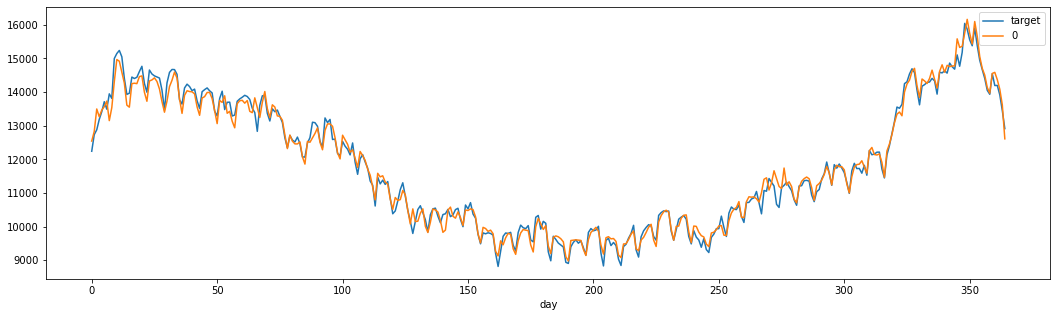

In [390]:
y_true_grouped.plot(figsize=(18,5))
ax=plt.gca()
y_pred_grouped.plot(ax=ax)

In [391]:
for quarter in quarters:
    mae = mae_day(quarter['target'], lgbm_model.predict(quarter['features']))
    print(f'mae_of_the_day - {mae}')

mae_of_the_day - 212.80539977117004
mae_of_the_day - 145.76126392708616
mae_of_the_day - 131.2702918348477
mae_of_the_day - 146.14154853928437


In [394]:
features_2023, target_2023, date_2023 = features_interval(features, target, '2023-01-01', '2024-01-01')
mae = mae_day(target_2023, lgbm_model.predict(features_2023))
print(f'mae_of_the_day - {mae}')

mae_of_the_day - 164.92834678824323


In [392]:
y_true_grouped['target'][1]

12734.276

<AxesSubplot:ylabel='0'>

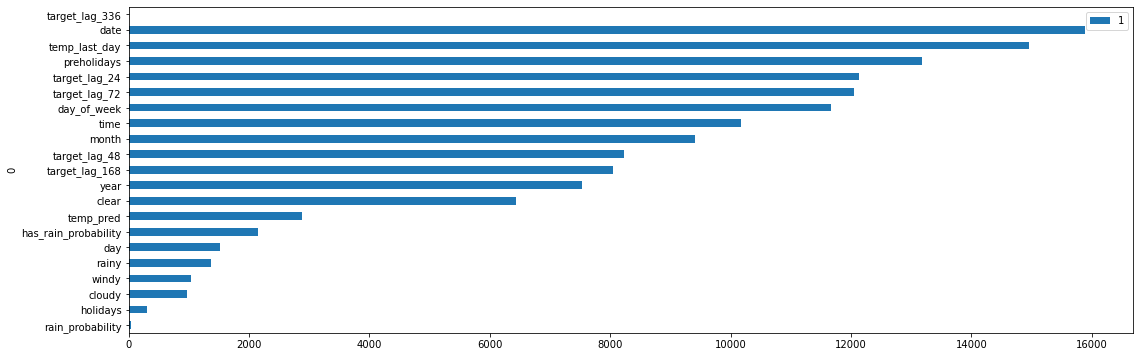

In [393]:
feature_importances = pd.DataFrame([feature_cols, lgbm_model.feature_importances_]).T.sort_values(by = 1)
feature_importances.plot(kind='barh', x=0, y=1, figsize=(18, 6))